# Tite-seq modeling

Ideas for modeling Tite-seq data, building on Tyler's work at https://github.com/jbloomlab/Ab-CGGnaive_DMS/blob/main/results/summary/compute_binding_Kd.md

In [1]:
from jax import config
config.update("jax_enable_x64", True)

import numpy as np
import scipy
import jax.numpy as jnp
import jax
from scipy.special import expit, logit
from jax.scipy.special import expit as jexpit, logit as jlogit
from scipy.optimize import least_squares
import jaxopt
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fcsparser
import urllib

In [2]:
outdir = "output/tite-seq-modeling"

## Data

Load tite-seq data

In [3]:
barcode_runs = pd.read_csv("~/Downloads/barcode_runs.csv")
barcode_runs.query("sample.str.startswith('TiteSeq')", inplace=True)
barcode_runs.set_index(["library", "sample"], inplace=True)
variant_counts = pd.read_csv("~/Downloads/variant_counts.csv")
variant_counts.query("sample.str.startswith('TiteSeq')", inplace=True)
codon_variant_table = pd.read_csv("~/Downloads/codon_variant_table.csv")
# codon_variant_table.query("n_aa_substitutions == 1", inplace=True)

Define concentrations and bins

In [137]:
concs = np.array([1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 0])
bins = np.array([1, 2, 3, 4])
b = np.array([-288., 136., 2000., 29421., 262143.])
# b[0] = 0.0
bins, b

(array([1, 2, 3, 4]),
 array([-2.88000e+02,  1.36000e+02,  2.00000e+03,  2.94210e+04,
         2.62143e+05]))

Combine tables to make a single barcode level frame

In [7]:
df_barcodes = variant_counts.merge(codon_variant_table, on=("barcode", "library"), how="inner")
df_barcodes["antigen_concentration"] = concs[df_barcodes["sample"].str.extract(r"TiteSeq_(\d+)").astype(int) - 1]
df_barcodes["bin"] = df_barcodes["sample"].str[-1].astype(int)
df_barcodes.drop(columns=["codon_substitutions", "n_codon_substitutions", "target", "variant_call_support"], inplace=True)
df_barcodes.rename(columns={"aa_substitutions": "variant",
                            "count": "read_count"},
                   inplace=True)
df_barcodes = df_barcodes.loc[:, ["sample", "library", "variant", "n_aa_substitutions", "barcode", "antigen_concentration", "bin", "read_count"]]
df_barcodes.sort_values(by=list(df_barcodes.columns), inplace=True)
df_barcodes.variant = df_barcodes.variant.fillna("WT")

df_barcodes

,sample,library,variant,n_aa_substitutions,barcode,antigen_concentration,bin,read_count
88956,TiteSeq_01_bin1,lib1,A104C,1,AAAAACATCAGTTGGT,0.000001,1,0
103644,TiteSeq_01_bin1,lib1,A104C,1,AAAACACTATCTAGGA,0.000001,1,0
134352,TiteSeq_01_bin1,lib1,A104C,1,AAAATTCAAAATTATC,0.000001,1,0
235440,TiteSeq_01_bin1,lib1,A104C,1,AACAAAAGTGTATGTT,0.000001,1,0
397908,TiteSeq_01_bin1,lib1,A104C,1,AAGTTATGAATACCCT,0.000001,1,0
...,...,...,...,...,...,...,...,...
6925787,TiteSeq_09_bin4,lib2,WT,0,TTTTTCATGTATATGC,0.000000,4,0
6927047,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAAAGTTCATA,0.000000,4,0
6927155,TiteSeq_09_bin4,lib2,WT,0,TTTTTTACCTTTACCT,0.000000,4,0
6927227,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAGAAGCGAAG,0.000000,4,0


In [8]:
barcode_runs

sample_type  sort_bin  concentration    date  \
library sample                                                         
lib1    TiteSeq_01_bin1     TiteSeq         1            1.0  210624   
        TiteSeq_01_bin2     TiteSeq         2            1.0  210624   
        TiteSeq_01_bin3     TiteSeq         3            1.0  210624   
        TiteSeq_01_bin4     TiteSeq         4            1.0  210624   
        TiteSeq_02_bin1     TiteSeq         1            2.0  210624   
...                             ...       ...            ...     ...   
lib2    TiteSeq_08_bin4     TiteSeq         4            8.0  210624   
        TiteSeq_09_bin1     TiteSeq         1            9.0  210624   
        TiteSeq_09_bin2     TiteSeq         2            9.0  210624   
        TiteSeq_09_bin3     TiteSeq         3            9.0  210624   
        TiteSeq_09_bin4     TiteSeq         4            9.0  210624   

                         number_cells  \
library sample                          
lib1    TiteSeq_01_bin1          9967   
        TiteSeq_01_bin2        100694   
        TiteSeq_01_bin3        910229   
        TiteSeq_01_bin4       4152079   
        TiteSeq_02_bin1         78772   
...                               ...   
lib2    TiteSeq_08_bin4            23   
        TiteSeq_09_bin1       5016672   
        TiteSeq_09_bin2         86684   
        TiteSeq_09_bin3            50   
        TiteSeq_09_bin4             3   

                                                                        R1  
library sample                                                              
lib1    TiteSeq_01_bin1  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_01_bin2  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_01_bin3  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_01_bin4  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_02_bin1  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
...                                                                    ...  
lib2    TiteSeq_08_bin4  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin1  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin2  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin3  /shared/ngs/illumina/tstarr/210728_D00300_1288...  
        TiteSeq_09_bin4  /shared/ngs/illumina/tstarr/210728_D00300_1288...  

[72 rows x 6 columns]

Use total cell counts and total read counts in each concentration and bin to estimate the number of cells with each barcode

In [9]:
def normalize_read_count(df):
    library = df.library.iloc[0]
    sample = df["sample"].iloc[0]
    total_reads = df.read_count.sum()
    total_cells = barcode_runs.number_cells[(library, sample)]
    df["estimated_cell_count"] = total_cells * df.read_count / total_reads
    return df

df_barcodes = df_barcodes.groupby(["library", "sample"]).apply(normalize_read_count).reset_index(drop=True)
df_barcodes

,sample,library,variant,n_aa_substitutions,barcode,antigen_concentration,bin,read_count,estimated_cell_count
0,TiteSeq_01_bin1,lib1,A104C,1,AAAAACATCAGTTGGT,0.000001,1,0,0.0
1,TiteSeq_01_bin1,lib1,A104C,1,AAAACACTATCTAGGA,0.000001,1,0,0.0
2,TiteSeq_01_bin1,lib1,A104C,1,AAAATTCAAAATTATC,0.000001,1,0,0.0
3,TiteSeq_01_bin1,lib1,A104C,1,AACAAAAGTGTATGTT,0.000001,1,0,0.0
4,TiteSeq_01_bin1,lib1,A104C,1,AAGTTATGAATACCCT,0.000001,1,0,0.0
...,...,...,...,...,...,...,...,...,...
6927439,TiteSeq_09_bin4,lib2,WT,0,TTTTTCATGTATATGC,0.000000,4,0,0.0
6927440,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAAAGTTCATA,0.000000,4,0,0.0
6927441,TiteSeq_09_bin4,lib2,WT,0,TTTTTTACCTTTACCT,0.000000,4,0,0.0
6927442,TiteSeq_09_bin4,lib2,WT,0,TTTTTTAGAAGCGAAG,0.000000,4,0,0.0


## Barcode aggregation

The current $K_D$ estimation procedure does a separate fit for each barcode, then computes the median of the estimated $\log K_D$ across barcodes for each variant.
Should we instead aggregate read counts from all barcodes for a given variant, and estimate a single $K_D$?

In [10]:
df_variants = df_barcodes.groupby(["library", "variant", "n_aa_substitutions", "antigen_concentration", "bin"]).agg({"read_count": "sum",
                                                                                                                     "estimated_cell_count": "sum",
                                                                                                                     "barcode": "count"}).reset_index()
df_variants.sort_values(by=list(df_variants.columns), inplace=True)
df_variants

,library,variant,n_aa_substitutions,antigen_concentration,bin,read_count,estimated_cell_count,barcode
0,lib1,A104C,1,0.000000e+00,1,2663,1245.976128,25
1,lib1,A104C,1,0.000000e+00,2,25,24.182027,25
2,lib1,A104C,1,0.000000e+00,3,0,0.000000,25
3,lib1,A104C,1,0.000000e+00,4,0,0.000000,25
4,lib1,A104C,1,1.000000e-13,1,578,1488.709081,25
...,...,...,...,...,...,...,...,...
821551,lib2,Y94W R145M,2,1.000000e-07,4,26,15.382275,1
821552,lib2,Y94W R145M,2,1.000000e-06,1,0,0.000000,1
821553,lib2,Y94W R145M,2,1.000000e-06,2,0,0.000000,1
821554,lib2,Y94W R145M,2,1.000000e-06,3,0,0.000000,1


In [11]:
read_count_marginals = df_variants.groupby(["library", "antigen_concentration"]).read_count.sum().reset_index()
read_count_marginals

,library,antigen_concentration,read_count
0,lib1,0.000000e+00,10776040
1,lib1,1.000000e-13,2100259
2,lib1,1.000000e-12,10367850
3,lib1,1.000000e-11,12182504
4,lib1,1.000000e-10,5913593
5,lib1,1.000000e-09,11274957
6,lib1,1.000000e-08,13181207
7,lib1,1.000000e-07,14261369
8,lib1,1.000000e-06,12550549
9,lib2,0.000000e+00,8064065


We filter missing concentrations for each barcode in the barcode data, and for each variant in the variant data. Missing means the sum of reads is zero.

In [12]:
def conc_filter_fn(df):
    return all(df.groupby("antigen_concentration").read_count.sum() > 0)

In [13]:
df_barcodes = df_barcodes.groupby(["library", "variant", "n_aa_substitutions", "barcode"]).filter(conc_filter_fn)
df_variants = df_variants.groupby(["library", "variant", "n_aa_substitutions"]).filter(conc_filter_fn)

## Model elaborations

Model the latent fluorescence $z$ at each concentration $x$ via a log-normal distribution:
$$
\log z\mid x \sim \mathcal{N}\left(\log f(x), \ σ^2\right),
$$
with mean given by a scaled Hill function
$$
f(x) = \alpha\left(\frac{x}{x + K_d}\right) + \beta,
$$
where $\beta$ models cell autofluorescence, $\alpha$ is the maximum fluorescence increase (a function of variant surface expression), and $\sigma^2$ is the variance.
The probability that a variant appears within a fluorescence bin defined by the interval $[b_i, b_{i-1})$ is obtained by integrating the Gaussian over the bin interval:
$$
p_i = \Phi\left(\frac{\log b_i - \log f(x)}{\sigma}\right) - \Phi\left(\frac{\log b_{i-1} - \log f(x)}{\sigma}\right),
$$
where $\Phi$ is the CDF of the standard normal distribution.
We observe read count $y_i$ from the cells in each bin, which we model as a gamma mixture of Poissons (negative binomial):
$$
y_i \mid \lambda p_i \sim \mathrm{NB}\left(\frac{1}{\phi}, \frac{1}{1+\phi \lambda p_i}\right),
$$
where $\lambda$ is the mean read count per cell and $\phi$ is the overdispersion parameter.

**Note:** many of the parameters are shared by all variants.
Only $\alpha$, $\lambda$, and $K_d$ are variant-specific.

## FACS data

In [497]:
fcs_df = pd.DataFrame()

pe_grid = np.logspace(np.log10(b[1]) - 2, np.log10(b[-1]), 100)
logf_grid = np.log(pe_grid)

logf_pdfs1 = np.full((len(concs), len(logf_grid)), np.nan)
logf_pdfs2 = np.full((len(concs), len(logf_grid)), np.nan)

ct = 5
for library in (1, 2):
    for concentration_idx in range(len(concs)):
        ct += 1
        url = f"https://github.com/jbloomlab/Ab-CGGnaive_DMS/raw/main/exptl_data/210624_TiteSeq_CGG/FCS_scFvpos/Specimen_001_sample_{(library - 1) * len(concs) + concentration_idx + 1:03d}_P4_{ct:03d}.fcs"
        title_str = url.split("/")[-1].split(".")[0]
        file = f"{outdir}/{title_str}.fcs"
        urllib.request.urlretrieve(url, file)
        meta, fcs = fcsparser.parse(file, reformat_meta=True)
        spill_values = meta["SPILL"].split(',')
        n_ch = int(spill_values[0])
        spill_df = pd.DataFrame(np.array(spill_values[3:], dtype=np.float64).reshape((n_ch, n_ch)).T,
                                index=spill_values[1:3])
        fcs[spill_df.index] = np.linalg.solve(spill_df, fcs[spill_df.index].T).T
        fcs["sample"] = title_str
        library = (int(title_str.split("_")[3]) - 1) // len(concs) + 1
        concentration_idx = int(title_str.split("_")[3]) % len(concs) - 1
        concentration = concs[concentration_idx]
        fcs["library"] = library
        fcs["concentration"] = concentration
        fcs_df = pd.concat(
            (fcs_df,
             fcs[["library",
                  "sample",
                  "concentration",
                  "PE-A",
                  ]
                 ]
             ),
             ignore_index=True)
        
        # fcs["PE-A"] = np.clip(fcs["PE-A"], b[0], b[-1])

        not_truncated_idxs = np.where((fcs["PE-A"] > 0) & (fcs["PE-A"] < b[-1]))[0]
        kde = jax.scipy.stats.gaussian_kde(
            np.log(fcs["PE-A"].values[not_truncated_idxs]),
            bw_method=.1)
        truncated_fraction = (fcs["PE-A"] >= b[-1]).sum() / len(fcs)
        if library == 1:
            logf_pdfs1[concentration_idx, :] = kde(logf_grid) / jax.scipy.integrate.trapezoid(kde(logf_grid), x=logf_grid)
        else:
            logf_pdfs2[concentration_idx, :] = kde(logf_grid) / jax.scipy.integrate.trapezoid(kde(logf_grid), x=logf_grid)

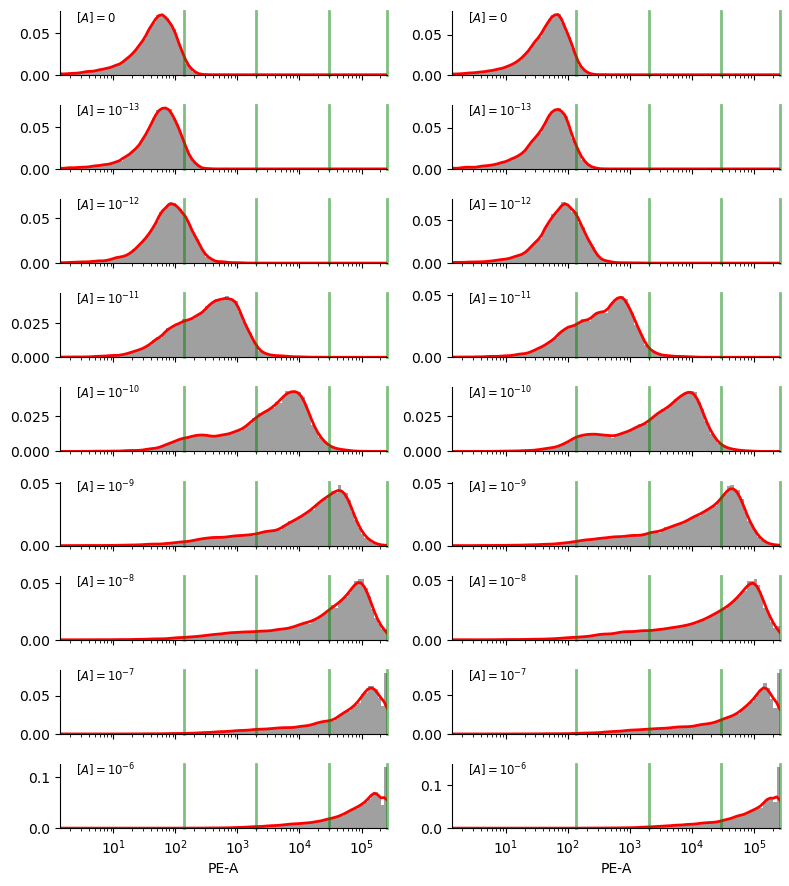

In [522]:
g = sns.displot(
    data=fcs_df.loc[(fcs_df["PE-A"] >= np.exp(logf_grid)[0]) & (fcs_df["PE-A"] <= np.exp(logf_grid)[-1])],
    x="PE-A",
    row="concentration",
    col="library",
    bins=np.exp(logf_grid),
    # bins=np.concatenate((np.linspace(fcs_df["PE-A"].min(), 0, 10), np.logspace(1, 6, 100))),
    # bins=fcs_df["PE-A"].min() + np.logspace(1, 6, 100),
    # stat="frequency",
    stat="probability",
    common_norm=False,
    color="gray",
    height=1, aspect=4,
    facet_kws=dict(sharey=False),
    )

g.set_ylabels("")
g.set_titles("")

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i, j].plot(np.exp(logf_grid),
                          (logf_pdfs1 if j == 0 else logf_pdfs2)[len(concs)-i - 1, :] / (logf_pdfs1 if j == 0 else logf_pdfs2)[len(concs)-i - 1, :].sum(),
                          color="r", lw=2)
        for bi in b[1:]:
            g.axes[i, j].axvline(bi, color="g", clip_on=False, alpha=0.5, lw=2)
            if g.row_names[i] > 0:
                power = int(np.log10(g.row_names[i]))
                title = f"$[A] = 10^{{{power}}}$"
            else:
                title = "$[A] = 0$"
            g.axes[i, j].set_title(title,
                        fontsize='small',
                        loc='left',
                        x=0.05,
                        y=0.7,
                        )

plt.xscale("log")
plt.xlim(np.exp(logf_grid[0]), np.exp(logf_grid[-1]))

plt.tight_layout()
plt.show()

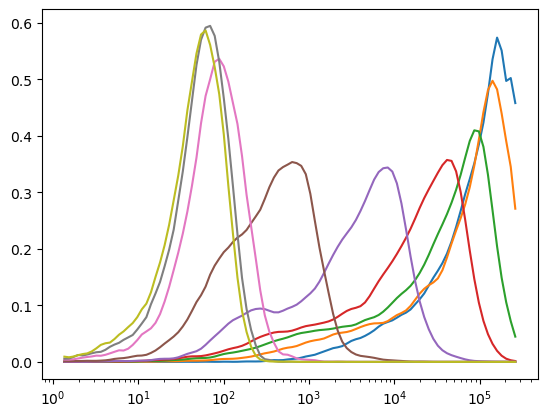

In [524]:
plt.plot(np.exp(logf_grid), logf_pdfs1.T)
plt.xscale("log")

In [525]:
scipy.stats.lognorm.pdf(1, 1, 1)

0.0

In [526]:
fcs_df["PE-A"] < b[0]

0         False
1         False
2         False
3         False
4         False
          ...  
351067    False
351068    False
351069    False
351070    False
351071    False
Name: PE-A, Length: 351072, dtype: bool

In [527]:
meta, data = fcsparser.parse(file, reformat_meta=True)

spill_values = meta["SPILL"].split(',')
n = int(spill_values[0])  # The first item is the number of channels
spill_df = pd.DataFrame(np.array(spill_values[3:], dtype=np.float64).reshape((n, n)).T,
                        index=spill_values[1:3],
                        columns=spill_values[1:3])
spill_df


,PE-A,FITC-A
PE-A,1.0000,0.003
FITC-A,0.0085,1.000


In [528]:
with pd.option_context("display.precision", 10):
    print("spillover matrix")
    display(spill_df)
    print("inverse spillover matrix")
    display(pd.DataFrame(np.linalg.inv(spill_df), index=spill_df.columns, columns=spill_df.columns))

spillover matrix


,PE-A,FITC-A
PE-A,1.0000,0.003
FITC-A,0.0085,1.000


inverse spillover matrix


,PE-A,FITC-A
PE-A,1.0000255007,-0.0030000765
FITC-A,-0.0085002168,1.0000255007


Spillover matrix mixes two true signals into two observed signals:
$$
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}
=
\begin{pmatrix}
1 & 0.003 \\
0.0085 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\mathrm{PE_{true}} \\
\mathrm{FITC_{true}} \\
\end{pmatrix}
$$
So to recover the true signals from the observed signals, we invert the matrix:
$$
\begin{align*}
\begin{pmatrix}
\mathrm{PE_{true}} \\
\mathrm{FITC_{true}} \\
\end{pmatrix}
&=
\begin{pmatrix}
1 & 0.003 \\
0.0085 & 1 \\
\end{pmatrix}^{-1}
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}\\
&=
\begin{pmatrix}
1.0000255007 & -0.0030000765 \\
-0.0085002168 & 1.0000255007 \\
\end{pmatrix}
\begin{pmatrix}
\mathrm{PE_{observed}} \\
\mathrm{FITC_{observed}} \\
\end{pmatrix}
\end{align*}\\
$$

/opt/miniconda3/envs/replay/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


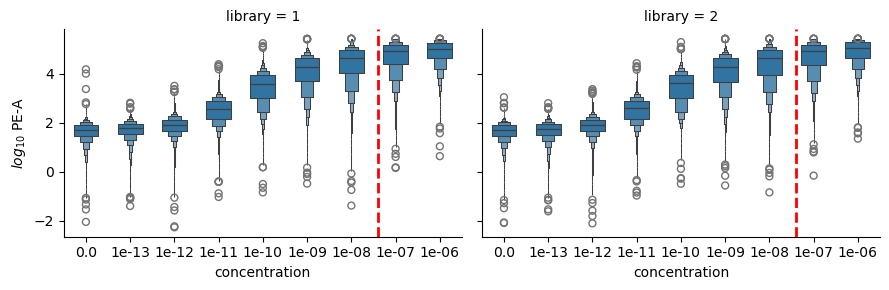

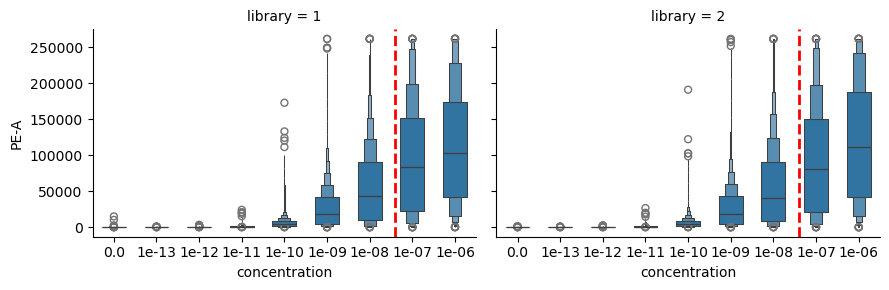

In [529]:
fcs_df["$log_{10}$ PE-A"] = np.log10(fcs_df["PE-A"])
for yval in ("$log_{10}$ PE-A", "PE-A"):
    g = sns.catplot(data=fcs_df,
                    kind="boxen",
                    col="library",
                    x="concentration",
                    y=yval,
                    gap=.3,
                    height=3, aspect=1.5,
                )
    g.refline(x=6 + np.log10(4), color="r", linestyle='--', lw=2, label="BLI naive $K_D$")
    # plt.yscale("symlog", linthresh=100, linscale=0.2)
    # plt.ylim(b[0], 1.1 * b[-1])
    plt.tight_layout()
    plt.show()

In [530]:
logf_pdfs1 = np.flip(logf_pdfs1, axis=0)
logf_pdfs2 = np.flip(logf_pdfs2, axis=0)

Modeling functions

In [1560]:
# def logf(logx, logα, logβ, logKd):
#     n = 1.0  # Hill coefficient
#     return jnp.exp(logα) * jexpit(n * (logx - logKd)) + jnp.exp(logβ)

def f(logx, logα, logβ, logKd):
    n = 1.0  # Hill coefficient
    return jnp.exp(logα) * jexpit(n * (logx - logKd)) + jnp.exp(logβ)

# NOTE: this function assumes truncation on the high bin, so all counts above it are in that bin (infinite upper boundary)
def logp(logx, logα, logβ, logKd, b, logσ):
    b = jnp.array(b)
    fs = f(logx, logα, logβ, logKd)
    σ = jnp.exp(logσ)
    logcdf_points = jax.scipy.stats.norm.logcdf(jnp.log(b[1:-1]), loc=jnp.log(fs[:, None]), scale=σ)
    logsf_points = jax.scipy.stats.norm.logsf(jnp.log(b[1:-1]), loc=jnp.log(fs[:, None]), scale=σ)
    first = logcdf_points[:, 0, None]
    middle = jax.scipy.special.logsumexp(jnp.concatenate((logcdf_points[:, 1:, None], logcdf_points[:, 0:-1, None]),
                                                       axis=-1),
                                       b=jnp.array([1, -1]),
                                       axis=-1)
    # this accounts for the fact that the last bin includes all values above the last boundary
    last = logsf_points[:, -1, None]
    return jnp.concatenate((first, middle, last), axis=-1)     
    # return logcdf_points[:, 1:] + jnp.log1p(-jnp.exp(-jnp.diff(logcdf_points, axis=1)))
    # return jnp.concatenate((logcdf_points[:, jnp.array([1])],
    #                         logcdf_points[:, 2:-1] + jnp.log1p(-jnp.exp(-jnp.diff(logcdf_points[:, 1:-1], axis=1))),
    #                         jax.scipy.special.logsumexp(jnp.concatenate((logcdf_points[:, -2, None], jnp.zeros((logcdf_points.shape[0], 1))), axis=-1),
    #                                                     b=jnp.array([-1, 1]),
    #                                                     axis=-1)[:, None]
    #                         ),
    #                         axis=-1)
    # return jnp.concatenate((cdf_points[:, jnp.array([0])], jnp.diff(cdf_points, axis=1)), axis=-1)

def p(logx, logα, logβ, logKd, b, logσ):
    return jnp.exp(logp(logx, logα, logβ, logKd, b, logσ))

# @jax.jit
# def one_neg_log_likelihood(logα, logKd, y, logβ, logσ, logx, b):
#     γ # library fraction of this variant
#     c # 9x4 cell count matrix
#     r # 9x4 sequencing coverage per cell matrix
#     # now we have a compound poisson distribution for the read count in each (conc,bin)
#     # cell count Z ~ Pois(γc), read count Y|Z ~ Pois(rZ).
#     # Use the laws of total expectation and variance to get
#     # E[Y] = E[E[Y|Z]] = E[rZ] = rE[Z] = γcr
#     # Var[Y] = E[Var[Y|Z]] + Var[E[Y|Z]] = E[rZ] + Var[rZ] = rγc + r^2γc = rγc(1 + r)

#     # gah, we need to consider the the library fractions of variants depend on bin
#     μ = γ * c * r # read count poisson mean

#     γ * ctot * 

#     γ * p / (γs * ps).sum(0)


#     λ = γ * n # cell count poisson mean 


#     logp_ = logp(logx, logα, logβ, logKd, b, logσ)
#     # return -jax.scipy.stats.poisson.logpmf(y, λ * p_).sum()
#     φ = jnp.exp(logφ)
#     nbinom_n = 1 / φ
#     nbinom_p = jexpit(-logλ - logφ - logp_)
#     return -jax.scipy.stats.nbinom.logpmf(y, nbinom_n, nbinom_p).sum()

# vmap_one_neg_log_likelihood = jax.vmap(one_neg_log_likelihood, in_axes=(0, 0, 0, 0, None, None, None, None, None, None))

# @jax.jit
# def neg_log_likelihood(params, data, α_ridge=0.0, Kd_ridge=0.0):
#     logβ, logσ, logαs, logKds, logλ, logφ = params
#     Y, bcs, logx, b = data
#     logαs = logαs * jnp.ones(Y.shape[0])
#     logKds = logKds * jnp.ones(Y.shape[0])
#     return vmap_one_neg_log_likelihood(logαs, logKds, Y, bcs, logλ, logφ, logβ, logσ, logx, b).mean() + α_ridge * ((logαs - logαs.mean()) ** 2).sum() + Kd_ridge * ((logKds - logKds.mean()) ** 2).sum()

@jax.jit
def one_mean_bin_loss(logα, logKd, ynorm, logβ, logσ, logx, b, binfs,
                      ):
    mean_bin_dat = (ynorm * binfs).sum(1) / ynorm.sum(1)
    ps = p(logx, logα, logβ, logKd, b, logσ)
    mean_bin_model = (ps * binfs).sum(1) / ps.sum(1)
    w = jnp.log(ynorm.sum(-1, keepdims=True))
    # w = jnp.ones(Ynorm.shape[1])
    curve_fit_loss = (w * (mean_bin_model - mean_bin_dat) ** 2).sum()
    return curve_fit_loss

vmap_mean_bin_loss = jax.vmap(one_mean_bin_loss, in_axes=(0, 0, 0, None, None, None, None, None,
                                                          ))

@jax.jit
def mean_bin_loss(params, data,
                  prior_weight=0.0,
                #   L2_logα=0.0, L2_logKd=0.0,
                  ):
    logαs, logKds, logσ = params
    Ynorm, logx, b, binfs, logβ, logf_grid, logf_pdfs = data
    # Ynorm, logx, b, binfs, ref_idx = data
    logαs = logαs * jnp.ones(Ynorm.shape[0])
    logKds = logKds * jnp.ones(Ynorm.shape[0])

    curve_fit_loss = vmap_mean_bin_loss(logαs, logKds, Ynorm, logβ, logσ, logx, b, binfs,
                                        ).mean()
    # return curve_fit_loss
    # return (curve_fit_loss
    #         + L2_logα * ((logαs - logαs[ref_idx]) ** 2).mean()
    #         + L2_logKd * ((logKds - logKds[ref_idx]) ** 2).mean()
    #         )
    σ = jnp.exp(logσ)
    fs = f(logx[:, None], logαs[None, :], logβ, logKds[None, :])
    logf_pdfs_predicted = jax.scipy.stats.norm.pdf(logf_grid[None, :, None], loc=jnp.log(fs[:, None, :]), scale=σ).mean(-1)
    logf_pdfs_predicted = logf_pdfs_predicted / jax.scipy.integrate.trapezoid(logf_pdfs_predicted, x=logf_grid, axis=1)[:, None]
    # plt.plot(logf_grid, logf_pdfs.T, c="C0")
    # plt.plot(logf_grid, logf_pdfs_predicted.T, c="C1")
    # plt.show()
    # print(jax.scipy.integrate.trapezoid(logf_pdfs, x=logf_grid, axis=1))
    # print(jax.scipy.integrate.trapezoid(logf_pdfs_predicted, x=logf_grid, axis=1))
    prior_loss = jax.scipy.integrate.trapezoid((logf_pdfs_predicted - logf_pdfs) ** 2, x=logf_grid, axis=1).sum()

    return curve_fit_loss + prior_weight * prior_loss


In [1561]:
read_count_marginals = df_variants.groupby(["library", "antigen_concentration"]).read_count.sum().reset_index()
read_count_marginals = read_count_marginals.join(df_variants.groupby(["library", "antigen_concentration"]).barcode.count().reset_index().barcode)
read_count_marginals

,library,antigen_concentration,read_count,barcode
0,lib1,0.000000e+00,10742875,37748
1,lib1,1.000000e-13,2097318,37748
2,lib1,1.000000e-12,10341359,37748
3,lib1,1.000000e-11,12153958,37748
4,lib1,1.000000e-10,5897257,37748
5,lib1,1.000000e-09,11237441,37748
6,lib1,1.000000e-08,13138506,37748
7,lib1,1.000000e-07,14217509,37748
8,lib1,1.000000e-06,12510451,37748
9,lib2,0.000000e+00,8043357,40800


Jax data from pandas frames

In [1955]:
x = np.flip(concs)
logx = jnp.log(x)
libs = []
variants = []
variant_types = []
n_aa_substitutions = []
Y = []
bcs = []
Ynorm = []
for idx, ((lib, variant, n_aa_substitution), group_df) in enumerate(df_variants.groupby(["library", "variant", "n_aa_substitutions"])):
    y = group_df.read_count.values.reshape(len(x), -1)
    ynorm = group_df.estimated_cell_count.values.reshape(len(x), -1)
    libs.append(lib)
    variants.append(variant)
    if "*" in variant:
        variant_types.append("nonsense")
    elif variant != "WT":
        if n_aa_substitution == 1:
            variant_types.append(f"1 missense")
        elif n_aa_substitution > 1:
            variant_types.append(f">1 missense")
        else:
            raise ValueError
    else:
        variant_types.append("WT")
    n_aa_substitutions.append(n_aa_substitution)
    Y.append(y)
    assert len(group_df.barcode.unique()) == 1, group_df.barcode
    bcs.append(float(group_df.barcode.unique().squeeze()))
    Ynorm.append(ynorm)
libs = np.array(libs)
variants = np.array(variants)
variant_types = np.array(variant_types)
n_aa_substitutions = np.array(n_aa_substitutions)
Y = np.array(Y)
bcs = np.array(bcs)
Ynorm = np.array(Ynorm)

assert Y.shape == Ynorm.shape

In [1563]:
# read_count_marginals = read_count_marginals.join(df_variants.groupby(["library", "antigen_concentration"]).barcode.count().reset_index().barcode)
# read_count_marginals

Distribution of normalized read counts per variant

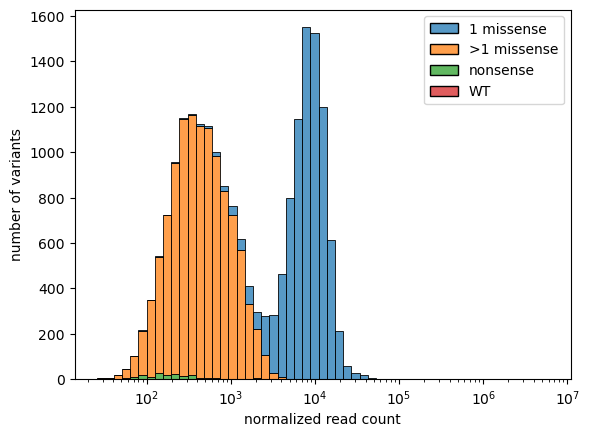

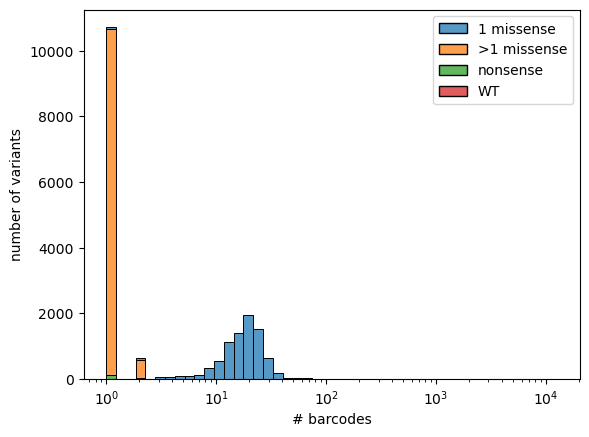

In [1956]:
sns.histplot(x=Ynorm.sum(-1).sum(-1),
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("normalized read count")
plt.ylabel("number of variants")
plt.show()

sns.histplot(x=bcs,
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("# barcodes")
plt.ylabel("number of variants")
plt.show()

Filter variants with low read counts

In [1957]:
# filter_idxs = (n_aa_substitutions <= 1) & (Y.sum(-1) > 10).all(-1)
filter_idxs = (Y.sum(-1) > 10).all(-1)
Y = Y[filter_idxs]
Ynorm = Ynorm[filter_idxs]
libs = libs[filter_idxs]
variants = variants[filter_idxs]
variant_types = variant_types[filter_idxs]
n_aa_substitutions = n_aa_substitutions[filter_idxs]
bcs = bcs[filter_idxs]

Y.shape

(15800, 9, 4)

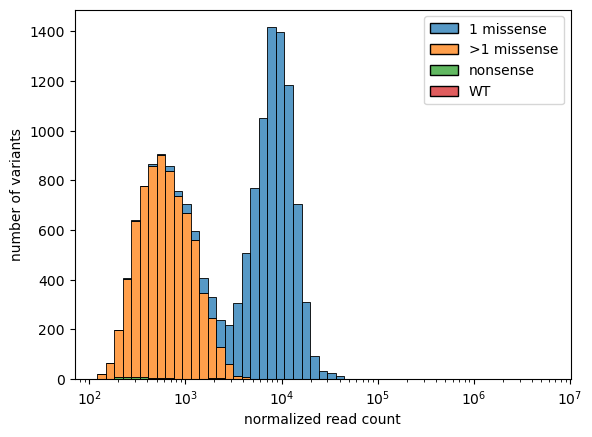

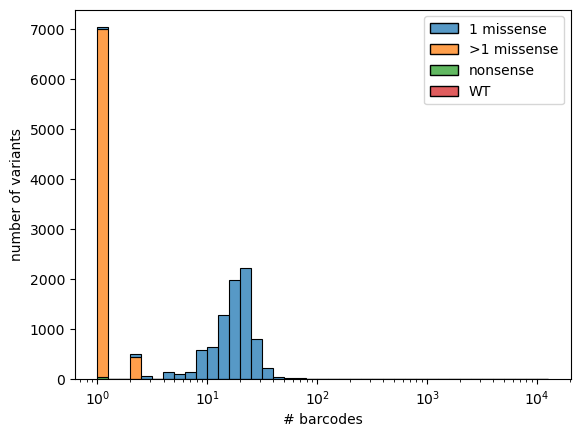

In [1958]:
sns.histplot(x=Ynorm.sum(-1).sum(-1),
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("normalized read count")
plt.ylabel("number of variants")
plt.show()

sns.histplot(x=bcs,
             hue=variant_types,
             multiple="stack",
             log_scale=True)
plt.xlabel("# barcodes")
plt.ylabel("number of variants")
plt.show()

indices of WT

In [1959]:
test_idx1, test_idx2 = np.where(variants == "WT")[0]

libs[test_idx1], variants[test_idx1], libs[test_idx2], variants[test_idx2]

('lib1', 'WT', 'lib2', 'WT')

indices of libraries

In [1960]:
lib1_idxs = np.where(libs == "lib1")[0]
lib2_idxs = np.where(libs == "lib2")[0]

Initialize parameters

In [1961]:
b

array([-2.88000e+02,  1.36000e+02,  2.00000e+03,  2.94210e+04,
        2.62143e+05])

In [1962]:
b, fcs_df["PE-A"].min(), fcs_df["PE-A"].max()

(array([-2.88000e+02,  1.36000e+02,  2.00000e+03,  2.94210e+04,
         2.62143e+05]),
 -388.5711330511975,
 262136.86717028863)

In [1963]:
def binfs_fn(df):
    result = pd.Series([np.log(df["PE-A"].loc[df["PE-A"] < b[1]]).mean(),
            np.log(df["PE-A"].loc[(df["PE-A"] >= b[1]) & (df["PE-A"] < b[2])]).mean(),
            np.log(df["PE-A"].loc[(df["PE-A"] >= b[2]) & (df["PE-A"] < b[3])]).mean(),
            np.log(df["PE-A"].loc[df["PE-A"] >= b[3]]).mean()],
            index=bins,
    )
    if pd.isna(result[1]):
        result[1] = np.log(b[1] / 2)
    if pd.isna(result[2]):
        result[2] = np.log(b[1] + (b[2] - b[1]) / 2)
    if pd.isna(result[3]):
        result[3] = np.log(b[2] + (b[3] - b[2]) / 2)
    if pd.isna(result[4]):
        result[4] = np.log(b[3] + (b[4] - b[3]) / 2)
    return result

binfs1 = fcs_df.query("library == 1").groupby("concentration").apply(binfs_fn).values
binfs2 = fcs_df.query("library == 2").groupby("concentration").apply(binfs_fn).values
binfs1, binfs2

/opt/miniconda3/envs/replay/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/replay/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([[ 3.67535567,  5.1029518 ,  8.84928666, 11.88986763],
        [ 3.8027649 ,  5.1255578 ,  9.66208456, 11.88986763],
        [ 3.96695796,  5.30006393,  7.83393444, 11.88986763],
        [ 4.05794371,  6.20638973,  8.06921064, 11.88986763],
        [ 4.21443269,  6.43628639,  8.79475605, 10.65593872],
        [ 3.94763998,  6.44813809,  9.27926545, 10.86366992],
        [ 3.96291979,  6.51484936,  9.23536877, 11.27990724],
        [ 4.02359372,  6.66549913,  9.19591443, 11.62314663],
        [ 3.56925577,  7.00021358,  9.3050182 , 11.68026997]]),
 array([[ 3.70144604,  5.10336554,  9.66208456, 11.88986763],
        [ 3.74420994,  5.12493838,  9.66208456, 11.88986763],
        [ 3.97271008,  5.27766209,  7.74602864, 11.88986763],
        [ 4.08805716,  6.20576978,  8.07307964, 11.88986763],
        [ 4.25937259,  6.39374475,  8.83492159, 10.65256475],
        [ 3.97367315,  6.43588833,  9.22710318, 10.87296893],
        [ 3.95195404,  6.52715668,  9.21514817, 11.30047172],
      

In [1424]:
def mean_bin_fn(df):
    library = df.library.unique().squeeze()
    if library == "lib1":
        binfs = binfs1
    elif library == "lib2":
        binfs = binfs2
    else:
        raise ValueError(library)
    concentration = df.antigen_concentration.unique().squeeze()
    concentration_idx = np.where(x == concentration)[0].squeeze()
    return np.exp(np.average(binfs[concentration_idx], weights=df.estimated_cell_count))

mean_bin_barcodes = df_barcodes.groupby(["library", "variant", "n_aa_substitutions", "barcode", "antigen_concentration"]).apply(mean_bin_fn).to_frame().reset_index().rename(columns={0: "bin_based_fluorescence"})
mean_bin_variants = df_variants.groupby(["library", "variant", "n_aa_substitutions", "antigen_concentration"]).apply(mean_bin_fn).to_frame().reset_index().rename(columns={0: "bin_based_fluorescence"})

display(mean_bin_barcodes)
display(mean_bin_variants)

,library,variant,n_aa_substitutions,barcode,antigen_concentration,bin_based_fluorescence,x,y
0,lib1,A104C,1,AAAACACTATCTAGGA,0.000000e+00,41.120160,0.000000e+00,3.716499
1,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-13,44.824950,1.000000e-13,3.802765
2,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-12,57.853982,1.000000e-12,4.057922
3,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-11,525.080754,1.000000e-11,6.263552
4,lib1,A104C,1,AAAACACTATCTAGGA,1.000000e-10,4709.793081,1.000000e-10,8.457399
...,...,...,...,...,...,...,...,...
1398109,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-10,598.092095,1.000000e-10,6.393745
1398110,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-09,14571.907049,1.000000e-09,9.586851
1398111,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-08,23843.684991,1.000000e-08,10.079275
1398112,lib2,Y94W R145M,2,AAAGAGACAACACGAT,1.000000e-07,51924.784913,1.000000e-07,10.857552


,library,variant,n_aa_substitutions,antigen_concentration,bin_based_fluorescence,x,y
0,lib1,A104C,1,0.000000e+00,40.549972,0.000000e+00,3.702535
1,lib1,A104C,1,1.000000e-13,46.202329,1.000000e-13,3.833030
2,lib1,A104C,1,1.000000e-12,64.506551,1.000000e-12,4.166767
3,lib1,A104C,1,1.000000e-11,437.484952,1.000000e-11,6.081042
4,lib1,A104C,1,1.000000e-10,5152.052021,1.000000e-10,8.547150
...,...,...,...,...,...,...,...
176728,lib2,Y94W R145M,2,1.000000e-10,598.092095,1.000000e-10,6.393745
176729,lib2,Y94W R145M,2,1.000000e-09,14571.907049,1.000000e-09,9.586851
176730,lib2,Y94W R145M,2,1.000000e-08,23843.684991,1.000000e-08,10.079275
176731,lib2,Y94W R145M,2,1.000000e-07,51924.784913,1.000000e-07,10.857552


/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_29058/1746211033.py:13: RuntimeWarning: divide by zero encountered in log
  logx_grid = np.log(x_grid)
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_29058/1746211033.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(b[0], b[-1])


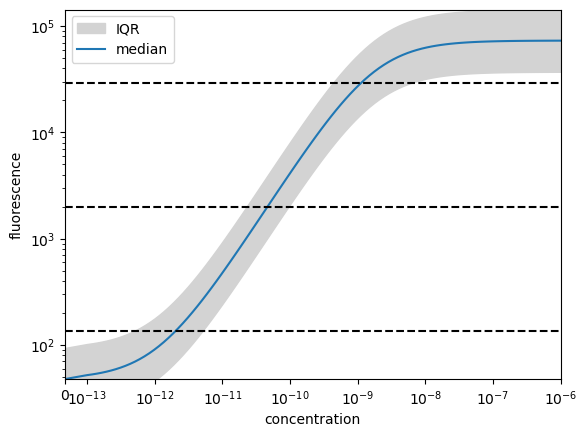

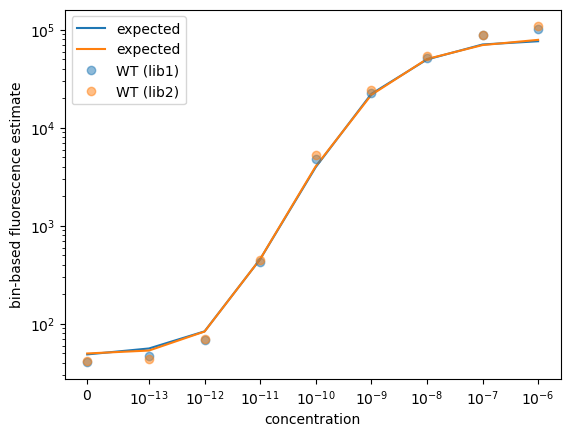

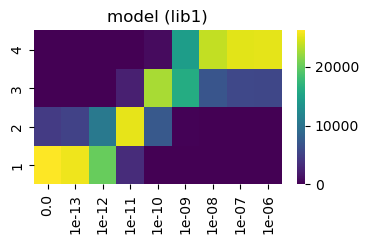

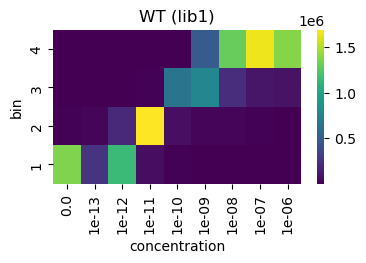

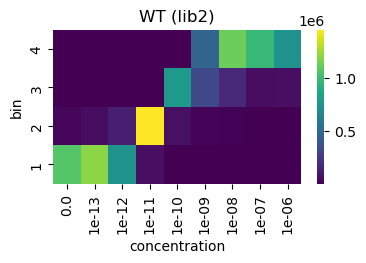

In [1964]:
logα = 11.2
logKd = -20.2
logσ = -0.

logβ = np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"].mean())
binfs = fcs_df.groupby

logλ = 1#jnp.log(read_count_marginals.query("library == 'lib1'").read_count.values / read_count_marginals.query("library == 'lib1'").barcode.values)[:, None]
# jnp.log(Y.sum((0, 2)))[:, None]
# logφ = -6.0

x_grid = np.array([0] + list(np.logspace(np.log10(x[1]), np.log10(x[-1]), 100)))
logx_grid = np.log(x_grid)
fs = f(logx_grid, logα, logβ, logKd)
scale = np.exp(logσ)
q25 = scipy.stats.lognorm.ppf(0.25, s=scale, scale=fs)
q75 = scipy.stats.lognorm.ppf(0.75, s=scale, scale=fs)
plt.fill_between(x_grid,
                 q25,
                 q75,
                 color="lightgray",
                 label="IQR")
plt.plot(x_grid, fs, label="median")
for b_ in b:
    plt.axhline(b_, color="k", linestyle="--")
plt.xscale("symlog", linthresh=x[1], linscale=0.3)
plt.yscale("log")
plt.ylim(b[0], b[-1])
plt.xlabel("concentration")
plt.ylabel("fluorescence")
plt.xlim(x[0], x[-1])
plt.ylim(fs[0], q75[-1])
plt.legend()
plt.show()

ps = p(logx, logα, logβ, logKd, b, logσ)
mean_binf1 = np.exp((binfs1 * ps).sum(1) / ps.sum(1))
mean_binf2 = np.exp((binfs2 * ps).sum(1) / ps.sum(1))
mean_binf_wt1 = np.exp((binfs1 * Ynorm[test_idx1]).sum(1) / Ynorm[test_idx1].sum(1))
mean_binf_wt2 = np.exp((binfs2 * Ynorm[test_idx2]).sum(1) / Ynorm[test_idx2].sum(1))

plt.plot(x, mean_binf1, label="expected", c="C0")
plt.plot(x, mean_binf2, label="expected", c="C1")
plt.plot(x, mean_binf_wt1, "o", label="WT (lib1)", alpha=0.5, c="C0")
plt.plot(x, mean_binf_wt2, "o", label="WT (lib2)", alpha=0.5, c="C1")
plt.xscale("symlog", linthresh=1e-13)
plt.yscale("log")
plt.xlabel("concentration")
plt.ylabel("bin-based fluorescence estimate")
plt.legend()
plt.show()

ps = p(logx, logα, logβ, logKd, b, logσ)

p_df = pd.DataFrame((ps * bcs[test_idx1] * np.exp(logλ)).T, columns=x, index=bins)
plt.figure(figsize=(4, 2))
ax = sns.heatmap(p_df, cmap="viridis")
ax.invert_yaxis()
plt.title(f"model (lib1)")
plt.show()

p_df = pd.DataFrame(Y[test_idx1].T, columns=pd.Series(x, name="concentration"), index=pd.Series(bins, name="bin"))
plt.figure(figsize=(4, 2))
ax = sns.heatmap(p_df, cmap="viridis")
ax.invert_yaxis()
plt.title(f"WT (lib1)")
plt.show()

p_df = pd.DataFrame(Y[test_idx2].T, columns=pd.Series(x, name="concentration"), index=pd.Series(bins, name="bin"))
plt.figure(figsize=(4, 2))
ax = sns.heatmap(p_df, cmap="viridis")
ax.invert_yaxis()
plt.title(f"WT (lib2)")
plt.show()

A simulation demonstration showing how amplitude and $K_D$ are confounded in mean-bin modeling

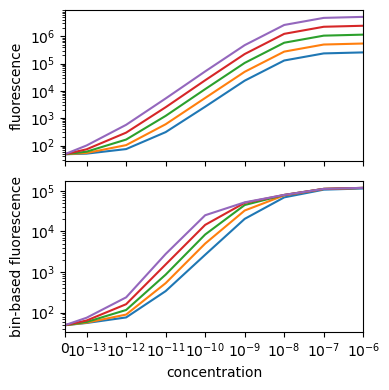

In [1965]:
fig, axs = plt.subplots(2, 1, figsize=(4, 4), sharex=True, sharey=False)
for logα_ in np.log(b[-1]) + np.linspace(0, 3, 5):
    logKd_ = np.log(1e-8)
    fs = f(logx, logα_, logβ, logKd_)
    axs[0].plot(x, fs)
    ps = p(logx, logα_, logβ, logKd_, b, logσ)
    mean_binf = np.exp((binfs1 * ps).sum(1) / ps.sum(1))
    axs[1].plot(x, mean_binf)
axs[0].set_yscale("log")
axs[0].set_ylabel("fluorescence")
axs[1].set_xscale("symlog", linthresh=1e-13, linscale=0.5)
axs[1].set_xlim(concs[-1], concs[0])
axs[1].set_yscale("log")
axs[1].set_xlabel("concentration")
axs[1].set_ylabel("bin-based fluorescence")
plt.tight_layout()
plt.show()

Loss surface for WT

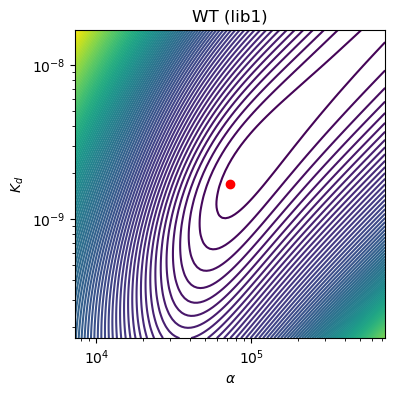

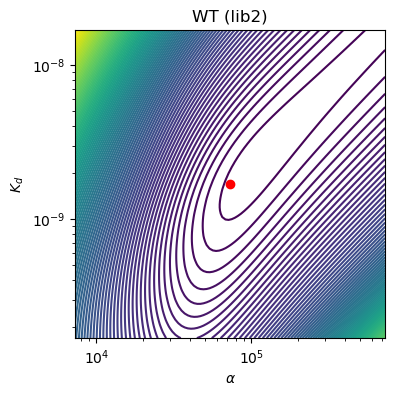

In [1966]:
for ct, (wt_idx, logf_pdfs, binfs) in enumerate(zip((test_idx1, test_idx2),
                                                    (logf_pdfs1, logf_pdfs2),
                                                    (binfs1, binfs2)),
                                                          1):
    # plot loss surface for Kd and α on one sample
    αs = np.exp(logα) * np.logspace(-1, 1, 100)
    Kds = np.exp(logKd) * np.logspace(-1, 1, 100)
    # αs, Kds = np.meshgrid(αs, Kds)
    loss = np.zeros((Kds.shape[0], αs.shape[0]))
    for i in range(Kds.shape[0]):
        for j in range(αs.shape[0]):
            # loss[i, j] = one_neg_log_likelihood(np.log(αs[j]), np.log(Kds[i]), Y[wt_idx], bcs[wt_idx], logλ, logφ, logβ, logσ, logx, b)
            
            # neg_log_likelihood((logβ, logσ, jnp.array([np.log(αs[j])]), jnp.array([np.log(Kds[i])]), logλ, logφ),
                                            # (jnp.array([Y[wt_idx]]), logx, b))    
            # logβ, logσ, logαs, logKds, logλ, logφ     
            loss[i, j] = one_mean_bin_loss(np.log(αs[j]), np.log(Kds[i]), Ynorm[wt_idx],
                                           logβ, logσ, logx, b, binfs,
                                           )
            # mean_bin_loss((logβ, logσ, jnp.array([np.log(αs[j])]), jnp.array([np.log(Kds[i])])),
            #                             (jnp.array([Ynorm[wt_idx]]), logx, b, bins),
            #                             )

    plt.figure(figsize=(4, 4))
    plt.contour(αs, Kds, loss, levels=100)
    plt.plot(np.exp(logα), np.exp(logKd), "o", color="r")
    plt.xlabel("$\\alpha$")
    plt.ylabel("$K_d$")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"WT (lib{ct})")
    plt.show()

Form data and params for optimizations

In [1967]:
data1 = Ynorm[lib1_idxs], logx, b, binfs1, np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"].mean()), logf_grid, logf_pdfs1
data2 = Ynorm[lib2_idxs], logx, b, binfs2, np.log(fcs_df.query("library == 1 & concentration == 0")["PE-A"].mean()), logf_grid, logf_pdfs2
# data1 = Ynorm[lib1_idxs], logx, b, binfs1, test_idx1
# data2 = Ynorm[lib2_idxs], logx, b, binfs2, test_idx2 - len(lib1_idxs)

# data1 = (Y[lib1_idxs], bcs[lib1_idxs], logx, b)
# data2 = (Y[lib2_idxs], bcs[lib2_idxs], logx, b)

In [1968]:
params0 = [logα, logKd, jnp.array(logσ)]

In [1969]:
# from jax import config
# config.update("jax_debug_nans", False)

mean_bin_loss(params0, data1), mean_bin_loss(params0, data2)

(Array(608.63765415, dtype=float64), Array(572.46784037, dtype=float64))

In [1970]:
# αs, Kds
@jax.jit
@jax.value_and_grad
def loss_block1(αKd, params, data, **kwargs):
    params[:2] = αKd
    return mean_bin_loss(params, data, **kwargs)

# σ
@jax.jit
@jax.value_and_grad
def loss_block2(σ, params, data, **kwargs):
    params[2] = σ
    return mean_bin_loss(params, data, **kwargs)

In [1971]:
# ProjectedGradient
opt = jaxopt.LBFGSB(
    jax.jit(jax.value_and_grad(mean_bin_loss)),
    # jaxopt.projection.projection_box,
    value_and_grad=True,
    maxiter=100, tol=1e-4,
    # linesearch="backtracking",
    # linesearch_init="current",
    # history_size=100,
    # stepsize=1.0,
    maxls=100,
    # max_stepsize=1e2, min_stepsize=1e-8,
    # verbose=True,
    jit=False,
)

In [1972]:
# opt_block1 = jaxopt.LBFGSB(
#     loss_block1,
#     # jaxopt.projection.projection_box,
#     value_and_grad=True,
#     maxiter=100, tol=1e-4,
#     # linesearch="backtracking",
#     # linesearch_init="current",
#     # history_size=30,
#     maxls=50,
#     # verbose=True,
#     jit=False,
# )

# opt_block2 = jaxopt.LBFGSB(
#     loss_block2,
#     # jaxopt.projection.projection_box,
#     value_and_grad=True,
#     maxiter=100, tol=1e-4,
#     # linesearch="backtracking",
#     # linesearch_init="current",
#     # history_size=30,
#     maxls=50,
#     # verbose=True,
#     jit=False,
# )

In [1973]:
def bounds(params):
    lb = [jnp.full_like(params[0], logα - 6),
          jnp.full_like(params[1], jnp.log(1e-12)),
          jnp.array(-0.75)]
    ub = [jnp.full_like(params[0], logα + 6),
          jnp.full_like(params[1], jnp.log(1e-4)),
          jnp.array(0.75)]
    return lb, ub

In [1974]:
# def bounds_block1(params):
#     lb = [jnp.full_like(params[0], logα - 5), jnp.full_like(params[1], jnp.log(1e-12))]
#     ub = [jnp.full_like(params[0], logα + 5), jnp.full_like(params[1], jnp.log(1e-4))]
#     return lb, ub

# def bounds_block2(params):
#     return -1.0, 1.0

In [1975]:
params1 = params0.copy()
params2 = params0.copy()

In [1976]:
params1 = [params1[0] * jnp.ones(len(lib1_idxs)),
           params1[1] * jnp.ones(len(lib1_idxs)),
           jnp.array(params1[2])]
params2 = [params2[0] * jnp.ones(len(lib2_idxs)),
           params2[1] * jnp.ones(len(lib2_idxs)),
           jnp.array(params2[2])]

In [1977]:
mean_bin_loss(params1, data1)

Array(608.63765415, dtype=float64)

In [1978]:
# loss_block1(params1[:2], params1, data1)

In [1979]:
# L2_logα = 0.0
# L2_logKd = 0.0
prior_weight = 1e-1

params1, state1 = opt.run(
    params1,
    bounds(params1),
    data1,
    # L2_logα=L2_logα,
    # L2_logKd=L2_logKd,
    prior_weight=prior_weight,
    )
print(f"lib1: {state1.iter_num} iterations, error={state1.error:.2e}, obj={mean_bin_loss(params1, data1, prior_weight):.2e}")

params2, state2 = opt.run(
    params2,
    bounds(params2),
    data2,
    # L2_logα=L2_logα,
    # L2_logKd=L2_logKd,
    prior_weight=prior_weight,
    )
print(f"lib2: {state2.iter_num} iterations, error={state2.error:.2e}, obj={mean_bin_loss(params2, data2, prior_weight):.2e}")

lib1: 100 iterations, error=2.08e-01, obj=3.72e+01
lib2: 100 iterations, error=1.48e-01, obj=4.57e+01


In [1980]:
# # from jax import config
# # config.update("jax_debug_nans", True)

# def block_descent_loop(n, params, data, prior_weight=0.0):
#     for _ in range(n):
#         params[:2], state = opt_block1.run(
#             params[:2],
#             bounds_block1(params[:2]),
#             params,
#             data,
#             prior_weight=prior_weight,
#             )
#         print(f"{state.iter_num} iterations, error={state.error:.2e}, obj={mean_bin_loss(params, data, prior_weight=prior_weight):.2e}")

#         params[2], state = opt_block2.run(
#             params[2],
#             bounds_block2(params[2]),
#             params,
#             data,
#             prior_weight=prior_weight,
#             )
#         print(f"{state.iter_num} iterations, error={state.error:.2e}, obj={mean_bin_loss(params1, data1, prior_weight=prior_weight):.2e}")

#     return params

In [1981]:
# params1 = block_descent_loop(5, params1, data1, prior_weight=1e-4)
# params2 = block_descent_loop(5, params2, data2, prior_weight=1e-4)

In [1982]:
# L2_logα = 0.0
# L2_logKd = 0.0

# for _ in range(1):
#     params1_block1, state1 = opt_block1.run(
#         params1,
#         bounds_block1(params1),
#         data1,
#         L2_logα=L2_logα,
#         L2_logKd=L2_logKd,
#         )
#     print(f"lib1: {state1.iter_num} iterations, error={state1.error:.2e}")


# for _ in range(1):
#     for bound_fn in (bounds_block1, bounds_block2):
#         params2, state2 = opt.run(params2,
#                                   bound_fn(params2),
#                                   data2,
#                                   L2_logα=L2_logα,
#                                   L2_logKd=L2_logKd,
#                                   )
#         print(f"lib2: {state2.iter_num} iterations, error={state2.error:.2e}")

In [1983]:
params1, params2

([Array([10.98155581, 10.50249503, 10.19822047, ..., 10.9336931 ,
         10.98407299, 10.79478801], dtype=float64),
  Array([-20.35644334, -19.73711903, -17.971614  , ..., -18.14337151,
         -21.03202612, -19.91880642], dtype=float64),
  Array(-0.53269117, dtype=float64)],
 [Array([11.10636699, 10.91410654, 11.07249316, ..., 11.20787922,
         12.15394042, 10.8398881 ], dtype=float64),
  Array([-20.11991725, -20.01890922, -20.0101026 , ..., -20.7897606 ,
         -20.81914419, -19.90989279], dtype=float64),
  Array(-0.53500829, dtype=float64)])

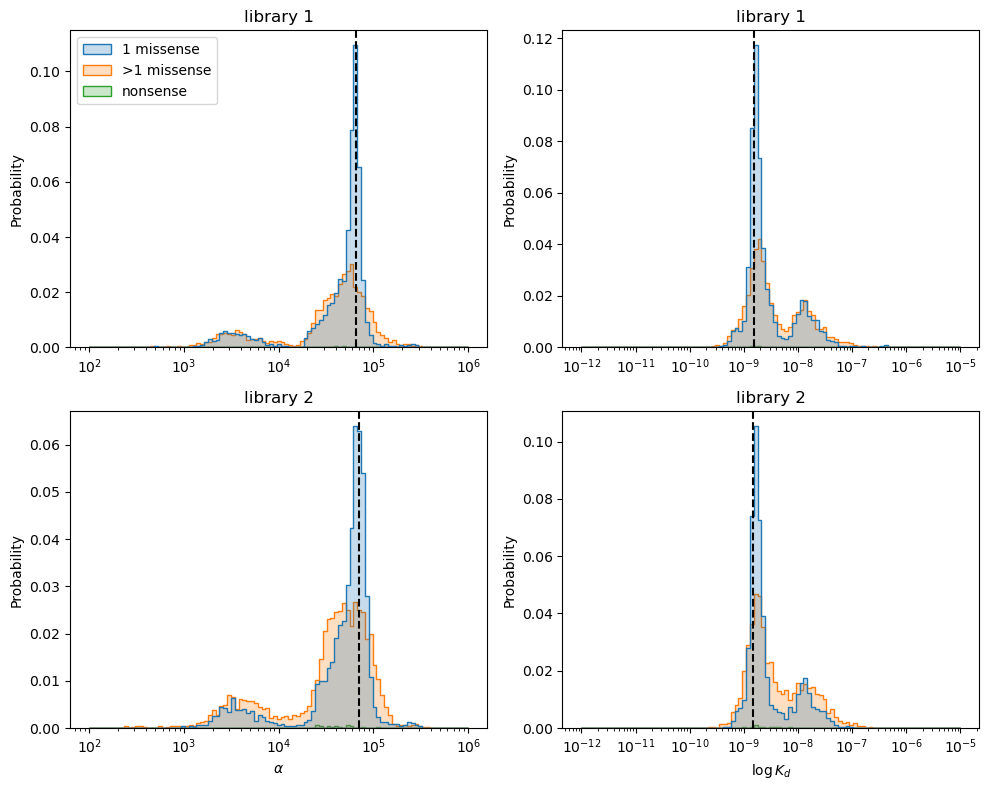

In [1984]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
sns.histplot(x=np.exp(params1[0]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
             bins=np.linspace(2, 6, 100),
             element="step",
             )
plt.axvline(np.exp(params1[0][test_idx1]), color="k", linestyle="--")
plt.title("library 1")
plt.subplot(223)
sns.histplot(x=np.exp(params2[0]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
             bins=np.linspace(2, 6, 100),
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[0][test_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$\\alpha$")
plt.subplot(222)
sns.histplot(x=np.exp(params1[1]),
             hue=variant_types[lib1_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
             bins=np.linspace(-12, -5, 100),
             element="step",
             legend=False,
             )
plt.title("library 1")
plt.axvline(np.exp(params1[1][test_idx1]), color="k", linestyle="--")
plt.subplot(224)
sns.histplot(x=np.exp(params2[1]),
             hue=variant_types[lib2_idxs],
             hue_order=("1 missense", ">1 missense", "nonsense"),
             log_scale=True,
             stat="probability",
            #  common_norm=False,
             bins=np.linspace(-12, -5, 100),
             element="step",
             legend=False,
             )
plt.axvline(np.exp(params2[1][test_idx2 - len(lib1_idxs)]), color="k", linestyle="--")
plt.title("library 2")
plt.xlabel("$\log K_d$")
plt.tight_layout()
plt.show()

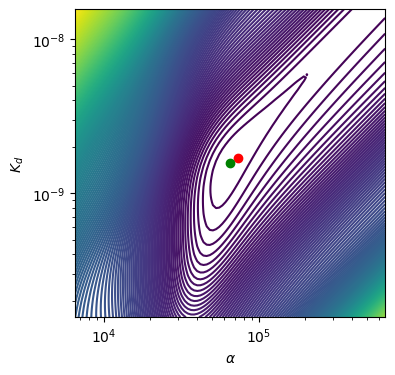

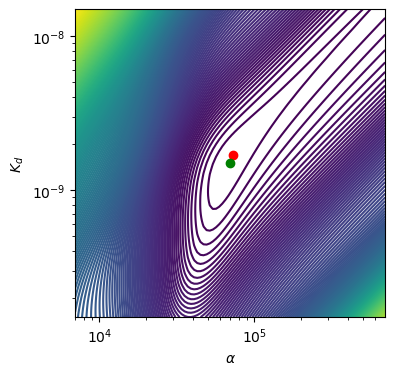

In [1985]:
for datai, paramsi, test_idxi in zip((data1, data2),
                                      (params1, params2),
                                      (test_idx1, test_idx2 - len(lib1_idxs))):
    Ynormi = datai[0].copy()
    logβi = datai[4]
    logσi = paramsi[2]
    binfsi = datai[3].copy()
    # plot loss surface for Kd and α on one sample
    αs = np.exp(paramsi[0][test_idxi]) * np.logspace(-1, 1, 100)
    Kds = np.exp(paramsi[1][test_idxi]) * np.logspace(-1, 1, 100)
    # αs, Kds = np.meshgrid(αs, Kds)
    loss = np.zeros((Kds.shape[0], αs.shape[0]))
    for i in range(Kds.shape[0]):
        for j in range(αs.shape[0]):
            # loss[i, j] = neg_log_likelihood((logβ, logσ, logγ, logφ, np.log(αs[j]), np.log(Kds[i]), logλs[0]),
            #                                (y, logx, b))        
            loss[i, j] = one_mean_bin_loss(np.log(αs[j]), np.log(Kds[i]), Ynormi[test_idxi], logβi, logσi,
                                           logx, b, binfsi,
                                           )

    plt.figure(figsize=(4, 4))
    plt.contour(αs, Kds, loss, levels=200)
    plt.plot(np.exp(params0[0]), np.exp(params0[1]), "o", color="r")
    plt.plot(np.exp(paramsi[0][test_idxi]), np.exp(paramsi[1][test_idxi]), "o", color="g")
    plt.xlabel("$\\alpha$")
    plt.ylabel("$K_d$")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
    # break

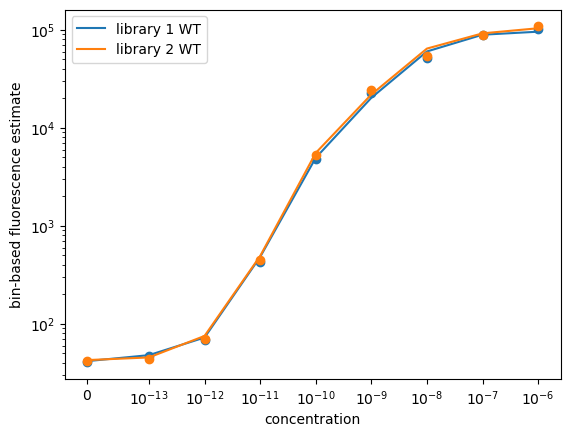

In [1986]:
ps = p(logx, params1[0][test_idx1], data1[4], params1[1][test_idx1], b, params1[2])
mean_binf = np.exp((binfs1 * ps).sum(1) / ps.sum(1))
mean_binf_wt = np.exp((binfs1 * Ynorm[test_idx1]).sum(1) / Ynorm[test_idx1].sum(1))
plt.plot(x, mean_binf, c="C0", label="library 1 WT")
plt.plot(x, mean_binf_wt, "o", c="C0")
ps = p(logx, params2[0][test_idx2 - len(lib1_idxs)], data2[4], params2[1][test_idx2 - len(lib1_idxs)], b, params2[2])
mean_binf = np.exp((binfs2 * ps).sum(1) / ps.sum(1))
mean_binf_wt = np.exp((binfs2 * Ynorm[test_idx2]).sum(1) / Ynorm[test_idx2].sum(1))
plt.plot(x, mean_binf, c="C1", label="library 2 WT")
plt.plot(x, mean_binf_wt, "o", c="C1")

plt.xscale("symlog", linthresh=1e-13)
plt.yscale("log")
plt.xlabel("concentration")
plt.ylabel("bin-based fluorescence estimate")
plt.legend()
plt.show()

In [1987]:
# ps = p(logx_grid, params1[0][test_idx1], data1[4], params1[1][test_idx1], b, params1[2])
# mean_bin = (bins[None, :] * ps).sum(1) / ps.sum(1)
# mean_bin_wt = (bins[None, :] * Ynorm[test_idx1]).sum(1) / Ynorm[test_idx1].sum(1)
# plt.plot(x_grid, mean_bin, c="C0")
# plt.plot(x, mean_bin_wt, "o", c="C0")
# ps = p(logx_grid, params2[0][test_idx2 - len(lib1_idxs)], data2[4], params2[1][test_idx2 - len(lib1_idxs)], b, params2[2])
# mean_bin = (bins[None, :] * ps).sum(1) / ps.sum(1)
# mean_bin_wt = (bins[None, :] * Ynorm[test_idx2]).sum(1) / Ynorm[test_idx2].sum(1)
# plt.plot(x_grid, mean_bin, c="C1")
# plt.plot(x, mean_bin_wt, "o", c="C1")

# plt.xscale("log")
# plt.ylim(bins[0], bins[-1])
# plt.show()

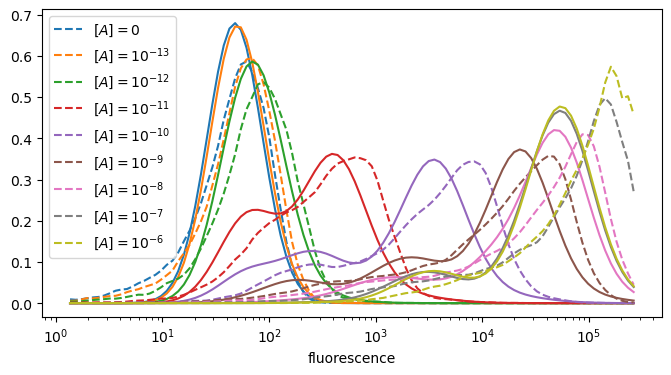

In [1988]:
plt.figure(figsize=(8, 4))
for i, logxi in enumerate(logx):
    fs = f(logxi, params1[0], data1[4], params1[1])
    curve = scipy.stats.norm.pdf(logf_grid, loc=jnp.log(fs[:, None]), scale=np.exp(params1[2])).mean(0)
    curve = curve / jax.scipy.integrate.trapezoid(curve, x=logf_grid)
    plt.plot(np.exp(logf_grid), curve, c=f"C{i}")
    if i == 0:
        label = "$[A]=0$"
    else:
        label = f"$[A]=10^{{{int(np.log10(x[i])):1d}}}$"
    plt.plot(np.exp(logf_grid), logf_pdfs1[i], c=f"C{i}", ls="--", label=label)
plt.xscale("log")
plt.xlabel("fluorescence")
plt.legend()
plt.show()

In [1989]:

Kd_variants = pd.DataFrame({"library": libs,
                            "variant": variants,
                            "n_aa_substitutions": n_aa_substitutions,
                            "variant_type": variant_types,
                            })
Kd_variants.loc[lib1_idxs, "expression"] = np.exp(params1[0])
Kd_variants.loc[lib2_idxs, "expression"] = np.exp(params2[0])
Kd_variants.loc[lib1_idxs, "log10Kd"] = np.array(params1[1]) / np.log(10)
Kd_variants.loc[lib2_idxs, "log10Kd"] = np.array(params2[1]) / np.log(10)

for lib in ("lib1", "lib2"):
    Kd_variants.loc[Kd_variants.library==lib, f"delta_log10Ka"] = Kd_variants.loc[(Kd_variants.library==lib) & (Kd_variants.variant=="WT"), "log10Kd"].squeeze() - Kd_variants.loc[Kd_variants.library==lib, "log10Kd"]

Kd_variants

,library,variant,n_aa_substitutions,variant_type,expression,log10Kd,delta_log10Ka
0,lib1,A104C,1,1 missense,58779.933767,-8.840691,0.035946
1,lib1,A104C A173E,2,>1 missense,36406.224182,-8.571722,-0.233023
2,lib1,A104C G105V,2,>1 missense,26855.353563,-7.804973,-0.999772
3,lib1,A104C L223F,2,>1 missense,34394.889216,-8.788860,-0.015885
4,lib1,A104D,1,1 missense,50964.012016,-8.677857,-0.126888
...,...,...,...,...,...,...,...
15795,lib2,Y94T S179Q,2,>1 missense,83547.354054,-8.887502,0.061955
15796,lib2,Y94V,1,1 missense,109488.405450,-9.081189,0.255642
15797,lib2,Y94V G113C,2,>1 missense,73708.928558,-9.028878,0.203331
15798,lib2,Y94V S112G,2,>1 missense,189840.669690,-9.041639,0.216092


In [1990]:
Kd_variants.query("variant == 'WT'").log10Kd

6855    -8.804745
15160   -8.825547
Name: log10Kd, dtype: float64

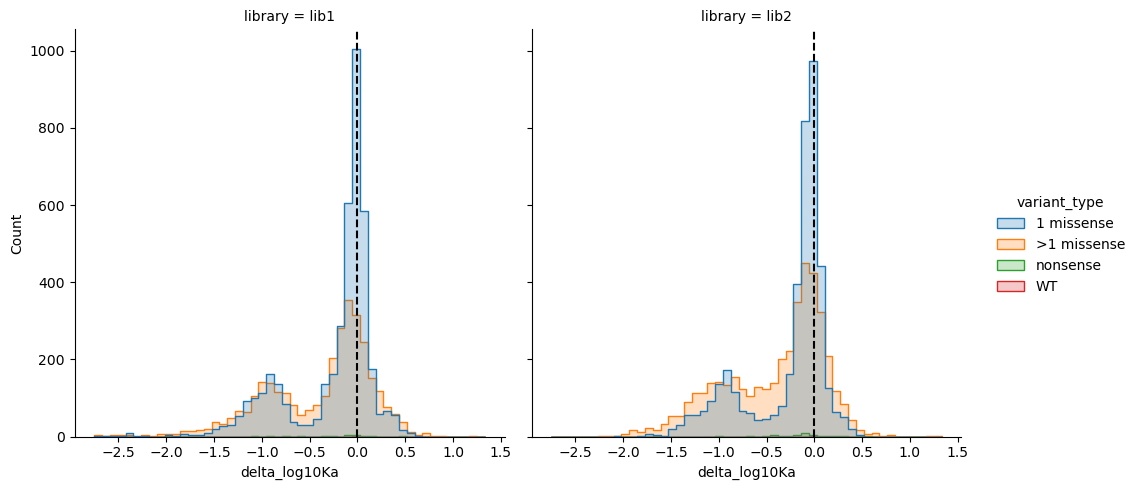

In [1991]:
g = sns.displot(Kd_variants,
                x="delta_log10Ka", col="library", hue="variant_type",
                bins=50,
                element="step"
                )
g.axes[0, 0].axvline(0, color="k", linestyle="--")
g.axes[0, 1].axvline(0, color="k", linestyle="--")
plt.show()

Show some titration curve fits

In [1992]:
plot_variants = pd.Series(["F225D", "Y176T", "V160D", "I129H", "Q16W", "L4T"])
plot_variants

0    F225D
1    Y176T
2    V160D
3    I129H
4     Q16W
5      L4T
dtype: object

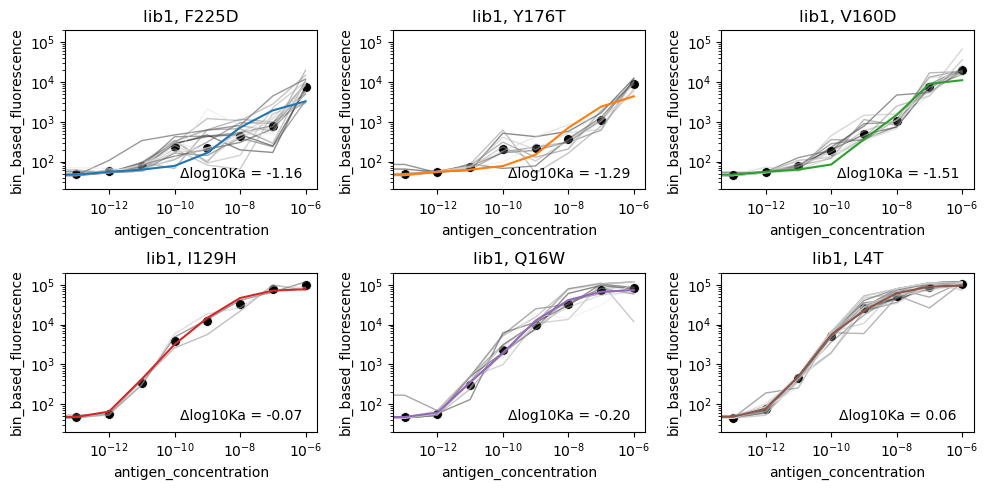

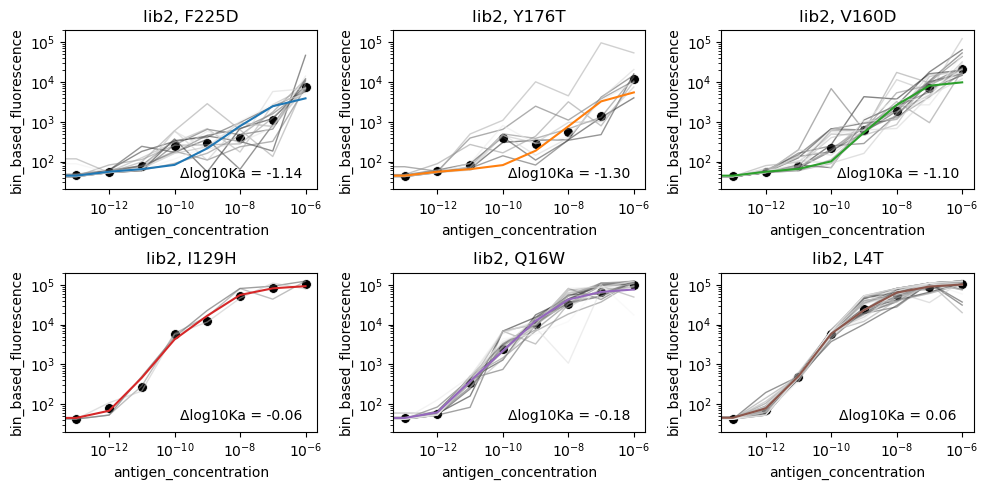

In [1993]:
for library, params, data, lib_idxs in zip(
    ("lib1", "lib2"),
    (params1, params2),
    (data1, data2),
    (lib1_idxs, lib2_idxs),
    ):
    plt.figure(figsize=(10, 5))
    for i, variant in enumerate(plot_variants):
        plt.subplot(2, 3, i + 1)
        plt.title(f"{library}, {variant}")
        sns.lineplot(data=mean_bin_barcodes.query("(library == @library) & (variant == @variant)"),
                    x="antigen_concentration", y="bin_based_fluorescence", hue="barcode",
                    palette="gray", lw=1,
                    alpha=0.5,
                    legend=False,
                    )
        sns.scatterplot(data=mean_bin_variants.query("(library == @library) & (variant == @variant)"),
                    x="antigen_concentration", y="bin_based_fluorescence",
                    color="k", alpha=1.0,
                    s=50,
                    )
        plt.annotate(f"Δlog10Ka = {Kd_variants.query('(library == @library) & (variant == @variant)').delta_log10Ka.squeeze():.2f}",
                    xy=(0.7, 0.1), xycoords="axes fraction",
                    ha="center", va="center",
                    )
        variant_idx = list(variants[lib_idxs]).index(variant)
        ps = p(logx, params[0][variant_idx], data[4], params[1][variant_idx], b, params[2])
        if library == "lib1":
            binfs = binfs1
        elif library == "lib2":
            binfs = binfs2
        else:
            raise ValueError(library)
        mean_bins = np.exp((binfs * ps).sum(1) / ps.sum(1))
        plt.plot(x, mean_bins, color=f"C{i}")
        plt.ylim(20, 2e5)
        plt.xscale("log")
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

$\log_{10} K_A$ correlation

Number of variants: 11630


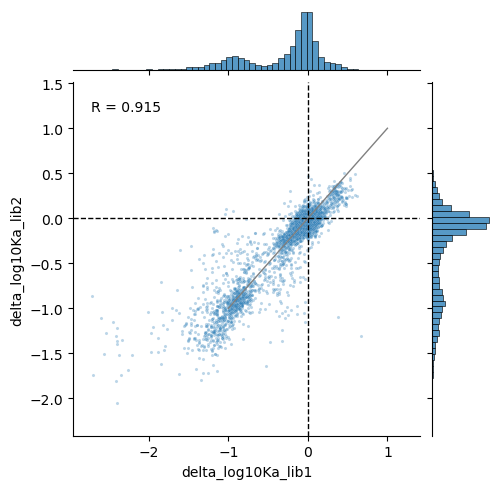

In [1994]:
pivoted = Kd_variants.pivot(index="variant", columns="library")
print(f"Number of variants: {len(pivoted)}")
pivoted.columns = pivoted.columns.map("_".join)
pivoted.drop("variant_type_lib2", axis=1, inplace=True)
pivoted.rename(columns={"variant_type_lib1": "variant_type"}, inplace=True)
sns.jointplot(data=pivoted, x="delta_log10Ka_lib1", y="delta_log10Ka_lib2",
              joint_kws=dict(alpha=0.3, s=5),
              height=5)
plt.annotate(f"R = {pearsonr(*pivoted[['delta_log10Ka_lib1', 'delta_log10Ka_lib2']].dropna().values.T).statistic:.3f}",
                (0.05, 0.95), xycoords="axes fraction", ha="left", va="top")
plt.plot([-1, 1], [-1, 1], color="gray", lw=1)
plt.axvline(0, color="black", lw=1, ls="--")
plt.axhline(0, color="black", lw=1, ls="--")
# plt.xlim(-6, 2)
# plt.ylim(-6, 2)

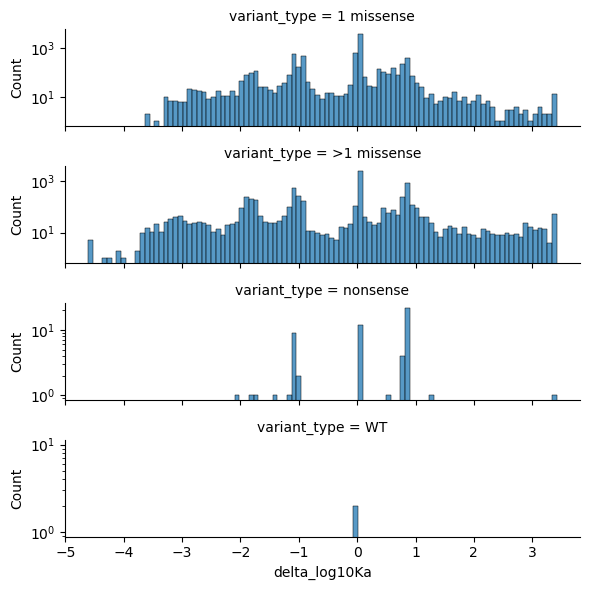

In [1943]:
sns.displot(data=Kd_variants,
             x="delta_log10Ka", row="variant_type",
             multiple="stack",
            #  row_order=["WT", "1", "2", "3", "4", "nonsense"],
            #  bins=30,
             common_norm=False, facet_kws=dict(sharey=False),
             log=True,
             height=1.5, aspect=4)      